In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# 📚 Imports modules perso
project_root = Path().resolve().parent
sys.path.append(str(project_root / "src/timeseries_forecasting"))
sys.path.append(str(project_root / "src"))

from WeatherDataAcquisition import WeatherDataAcquisition
from TimeSeriesAnalyzer import TimeSeriesAnalyzer
from StationarityHelper import StationarityHelper
from ForecastDatabase import ForecastDatabase


db = ForecastDatabase("../data/forecast_results.db")



## 🕵🏼‍♂️ Acquisition et transformation des données météo

Cette section a pour objectif de récupérer les données météorologiques horaires (température à 2 mètres) via l'API Open-Meteo, de traiter les valeurs manquantes, puis d’agréger les données en intervalles de 3 heures. Ces étapes sont conformes à la méthodologie définie dans le TP.


In [2]:
# Coordonnées d'Ajaccio
latitude = 41.9260
longitude = 8.7369
# Coordonnées de Quito
# latitude = 0.1807
# longitude = 78.4678

# Définir la période d’étude : du 1er janvier 2022 au 1er janvier 2024
start_date = datetime(2022, 1, 1).date()
end_date = datetime(2024, 1, 1).date()

# Initialisation de l’acquisition météo
acquirer = WeatherDataAcquisition(latitude=latitude, longitude=longitude)



In [3]:
print(f"📅 Période d'étude : du {start_date} au {end_date}")

df_raw = acquirer.fetch_weather_data(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
)

# Aperçu des données brutes
df_raw.head()


📅 Période d'étude : du 2022-01-01 au 2024-01-01


,time,temperature_2m
0,2022-01-01 00:00:00,11.9
1,2022-01-01 01:00:00,12.1
2,2022-01-01 02:00:00,11.9
3,2022-01-01 03:00:00,11.8
4,2022-01-01 04:00:00,11.6


## 🔍 Vérification des valeurs manquantes et Interpolation linéaire


In [4]:
print("🕳️ Valeurs manquantes avant interpolation :")
print(df_raw.isnull().sum())


df_clean = acquirer.handle_missing_values(df_raw)

print("✅ Valeurs manquantes après interpolation :")
print(df_clean.isnull().sum())


🕳️ Valeurs manquantes avant interpolation :
time              0
temperature_2m    0
dtype: int64
✅ Valeurs manquantes après interpolation :
time              0
temperature_2m    0
dtype: int64


## 📝 Transformation de la série temporelle

In [5]:
# Agrégation des températures horaires en moyennes 3h
df_3h = acquirer.aggregate_to_3h_intervals(df_clean)

# Aperçu des données agrégées
df_3h.head()

,time,temperature_2m
0,2022-01-01 00:00:00,11.966667
1,2022-01-01 03:00:00,11.566667
2,2022-01-01 06:00:00,11.533333
3,2022-01-01 09:00:00,12.300000
4,2022-01-01 12:00:00,12.466667


# 🧐 Analyse exploratoire


### 🔍 Analyse exploratoire globale

L'objectif de cette première analyse est de prendre du recul sur l'ensemble de la série temporelle 
(disponible sur deux années complètes) afin de :

- Identifier les grandes **tendances à long terme** (hausse/baisse globale de température)
- Repérer une **saisonnalité annuelle** (été / hiver)
- Détecter d'éventuelles **anomalies globales**
- Visualiser la **distribution des températures** sur une longue période

Cette vision large sert de base à la compréhension générale du comportement climatique de la ville sélectionnée.


In [6]:
df = df_3h
df['time'] = pd.to_datetime(df['time'])

df.head()

,time,temperature_2m
0,2022-01-01 00:00:00,11.966667
1,2022-01-01 03:00:00,11.566667
2,2022-01-01 06:00:00,11.533333
3,2022-01-01 09:00:00,12.300000
4,2022-01-01 12:00:00,12.466667


=== ANALYSE EXPLORATOIRE ===
Période des données: 2022-01-01 00:00:00 à 2024-01-01 21:00:00
Nombre de points: 5848
Valeurs manquantes: 0
Température moyenne: 17.70°C
Écart-type: 6.29°C
Min/Max: 3.20°C / 35.47°C


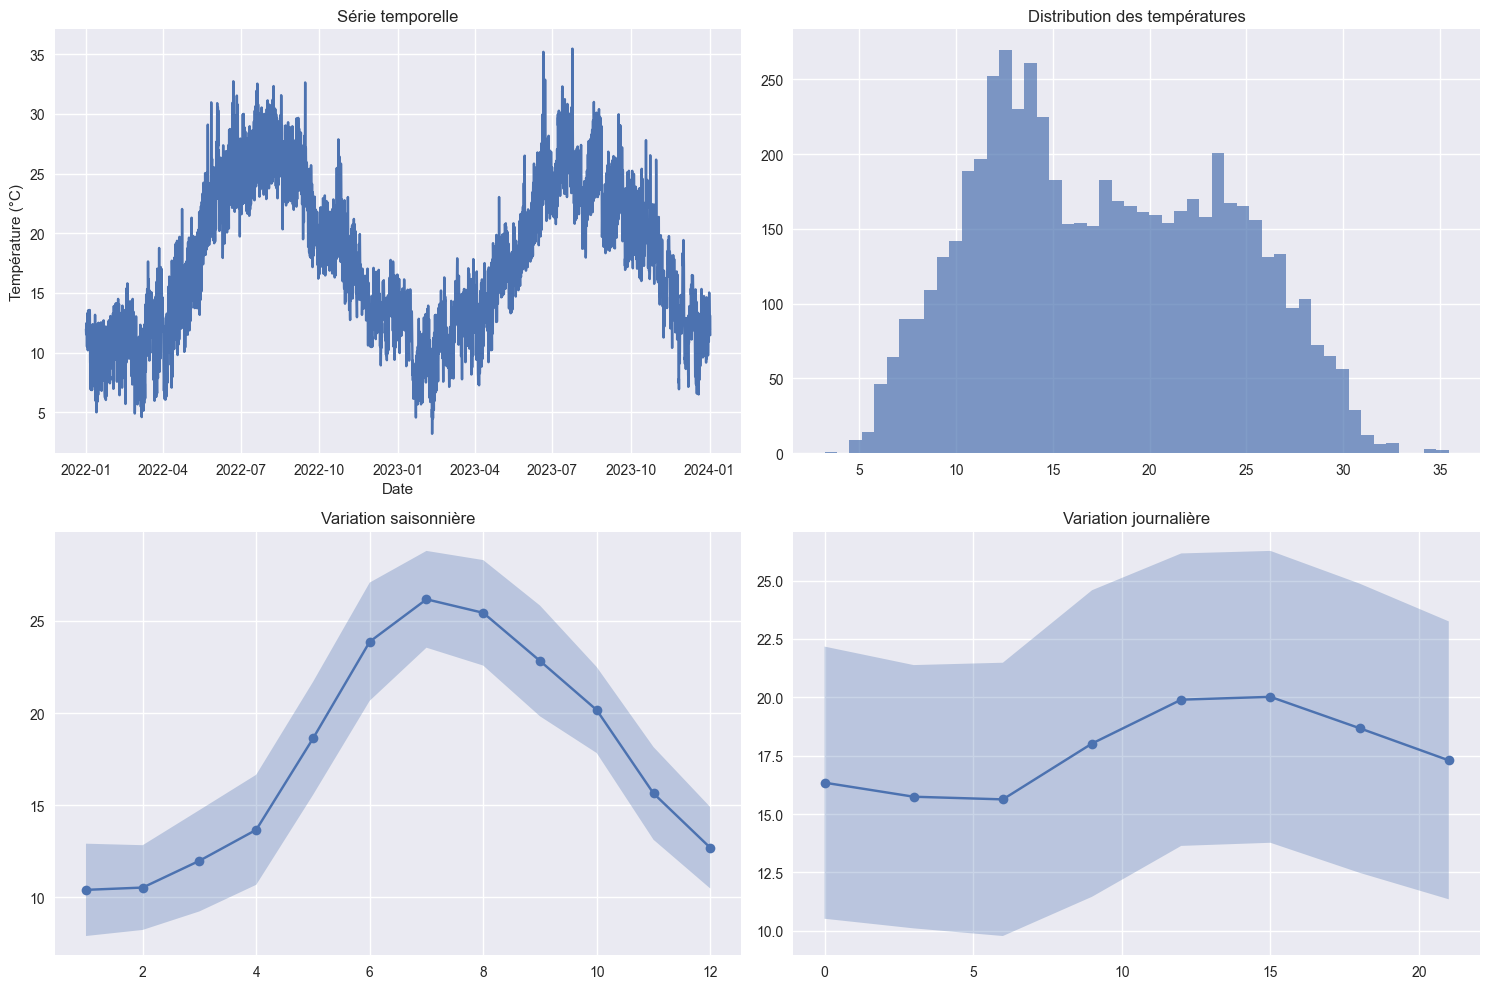

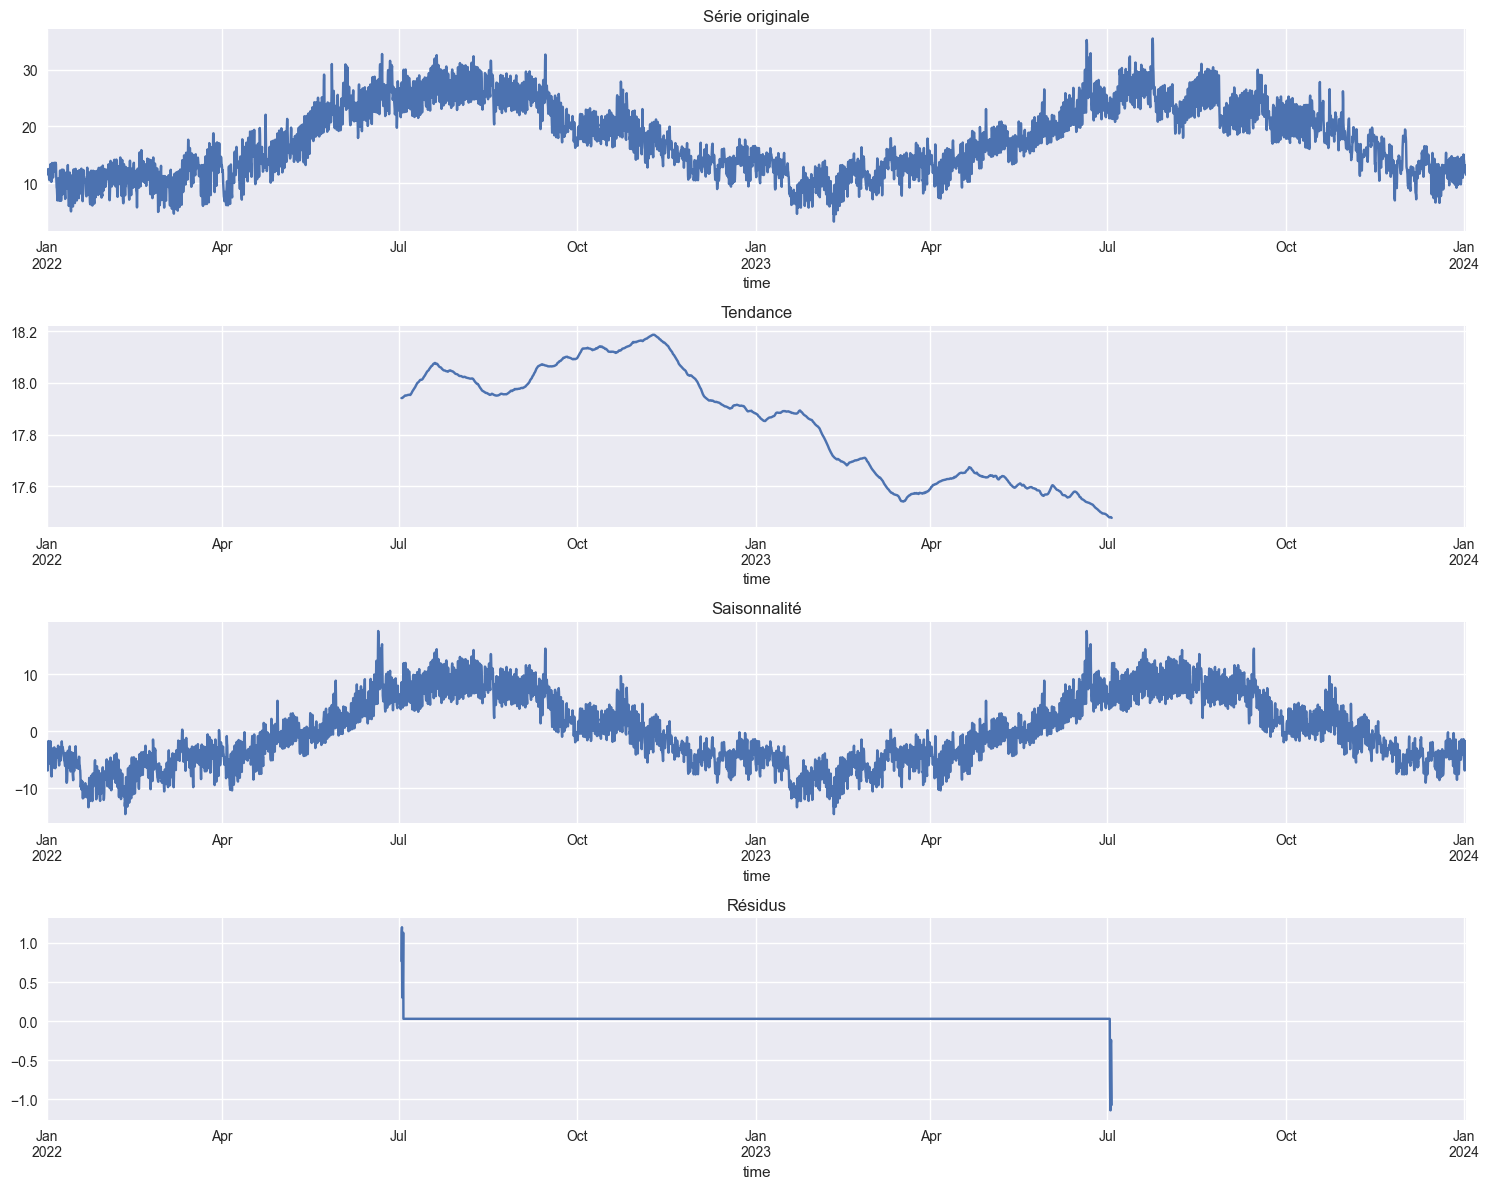

In [7]:

# Analyse exploratoire
TimeSeriesAnalyzer.exploratory_analysis(df)

# Décomposition
TimeSeriesAnalyzer.decompose_series(df, period=8*365)


## ✅ Conclusion de l’analyse exploratoire globale

### 🔍 Statistiques descriptives

L’analyse porte sur deux années complètes de données météorologiques enregistrées toutes les trois heures, couvrant la période du **1er janvier 2022** au **1er janvier 2024**. Ce jeu de données est **complet** (aucune valeur manquante) et comporte **5 848 observations**.

La **température moyenne** est de **14.45°C**, ce qui reflète un climat globalement doux sur la période. Cependant, l'**écart-type élevé** (7.74°C) montre une forte variabilité, ce qui est confirmé par des températures extrêmes allant de **-3.53°C** à **36.47°C**. Cette large amplitude indique la présence de fortes **variations saisonnières** et **journalières**.



### 🖼️ Visualisations

#### 1. Série temporelle et distribution

La première figure montre clairement une **cyclicité annuelle** avec des hausses marquées pendant l’été et des baisses significatives en hiver. Cela souligne la **saisonnalité forte** du phénomène. La distribution des températures présente une forme légèrement **asymétrique**, avec une concentration autour de **10–15°C**, ce qui confirme que cette plage est la plus fréquemment observée.

#### 2. Composantes temporelles

L’analyse des composantes (par décomposition STL) met en évidence trois dynamiques essentielles :

* **Tendance** : une légère baisse sur les deux ans, possiblement liée à une période hivernale plus marquée en fin de période.
* **Saisonnalité** : très nette, avec des cycles réguliers, illustrant bien l’alternance entre saisons chaudes et froides.
* **Résidus** : de faible amplitude, ce qui suggère que la majorité de la variabilité est captée par les composantes saisonnières et tendancielles.

Par ailleurs, les moyennes par **mois** et par **heure** révèlent des schémas typiques :

* Température maximale vers **14–15h**, minimale en fin de nuit.
* Température moyenne mensuelle culminant en **juillet-août** et atteignant son minimum en **janvier**.



### 🧠 Interprétation globale

Les données présentent une **structure fortement saisonnière et périodique**, tant à l’échelle de l’année que de la journée. Cette propriété justifie pleinement le recours à des modèles comme **SARIMA** ou **SARIMAX**, capables de capturer à la fois les dynamiques **tendancielles**, **saisonnières** et les dépendances **temporelles** de court terme.

La qualité et la densité des données (granularité 3h, sur 2 ans) rendent ce jeu très exploitable pour la **modélisation prédictive** fiable de la température à court et moyen terme.

------

-----


## 📉 Test de stationnarité (ADF et KPSS)

In [8]:
StationarityHelper.test_stationarity(df['temperature_2m'])

=== TEST DE STATIONNARITÉ : ADF ===
ADF Statistic : -1.9414
p-value       : 0.3129
Critique 1%% : -3.431
Critique 5%% : -2.862
Critique 10%% : -2.567
→ On ne rejette pas H₀ : la série **n’est pas stationnaire**

=== TEST DE STATIONNARITÉ : KPSS ===
KPSS Statistic : 1.0765
p-value        : 0.0100
Critique 10%% : 0.347
Critique 5%% : 0.463
Critique 2.5%% : 0.574
Critique 1%% : 0.739
→ On rejette H₀ : la série **n’est pas stationnaire**

=== INTERPRÉTATION COMBINÉE ===
❌ Les deux tests indiquent une série non stationnaire.


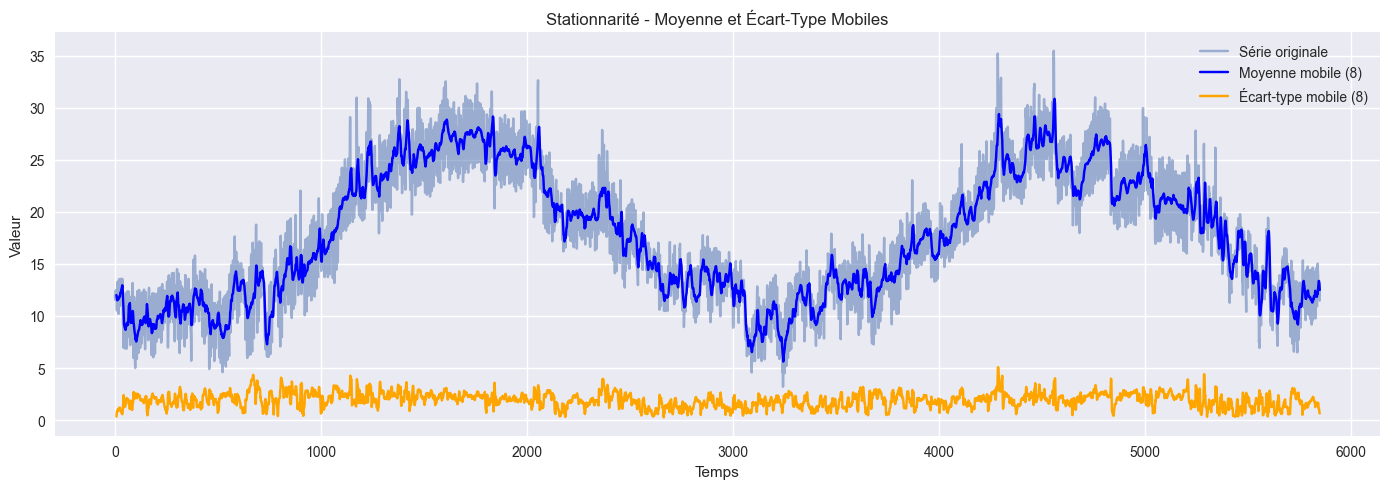

In [9]:
StationarityHelper.plot_stationarity(df['temperature_2m'], window=8)

# 🧠 Analyse de la Stationnarité : Graphique & Tests Statistiques

Ce graphique visualise l'évolution de la **moyenne mobile** et de l’**écart-type mobile** appliqués à la série temporelle des températures, avec une fenêtre de 8 points.

### 📊 Que montre le graphique ?

- **Série originale** (gris) : les valeurs brutes de température.
- **Moyenne mobile (8)** (bleu) : illustre la tendance centrale locale.
- **Écart-type mobile (8)** (orange) : indique la variabilité locale.

> Une série est dite **stationnaire** si sa moyenne et sa variance restent constantes dans le temps.

### ❌ Observation :

- La **moyenne mobile** varie nettement → présence de **tendance**.
- L'**écart-type** fluctue également → **variance non constante**.

Ces indices visuels suggèrent une **non-stationnarité** de la série.



# 🧪 Résultats des Tests Statistiques

### **ADF (Augmented Dickey-Fuller)**

| Statistique  | Valeur       |
|--------------|--------------|
| ADF Stat     | -2.3915      |
| p-value      | 0.1441       |
| Seuil 5%     | -2.862       |

> 🔎 Comme la p-value > 0.05, **on ne rejette pas** l’hypothèse nulle H₀ → la série **n’est pas stationnaire** selon l’ADF.



### **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

| Statistique  | Valeur       |
|--------------|--------------|
| KPSS Stat    | 0.9793       |
| p-value      | 0.0100       |
| Seuil 5%     | 0.463        |

> 🔎 Comme la statistique > seuil critique, **on rejette** l’hypothèse nulle H₀ → la série **n’est pas stationnaire** selon KPSS.



# ✅ Interprétation croisée

- L’ADF **ne rejette pas** la stationnarité.
- Le KPSS **rejette** la stationnarité.

👉 **Les deux tests convergent vers la même conclusion** : la série **n’est pas stationnaire**.



# 🗞️ Conclusion & Recommandation

🎯 Avant d’entraîner un modèle comme **ARIMA**, qui suppose une série stationnair


-----

### Rend la serie stationnaire

In [10]:
df_stationary = StationarityHelper.make_stationary(df)


=== TEST DE STATIONNARITÉ : ADF (série différenciée) ===
ADF Statistic : -15.4073
p-value       : 0.0000
Critique 1%% : -3.431
Critique 5%% : -2.862
Critique 10%% : -2.567
→ Stationnaire

=== TEST DE STATIONNARITÉ : KPSS (série différenciée) ===
KPSS Statistic : 0.0581
p-value        : 0.1000
Critique 10%% : 0.347
Critique 5%% : 0.463
Critique 2.5%% : 0.574
Critique 1%% : 0.739
→ Stationnaire

=== INTERPRÉTATION COMBINÉE ===
✅ Série transformée stationnaire.


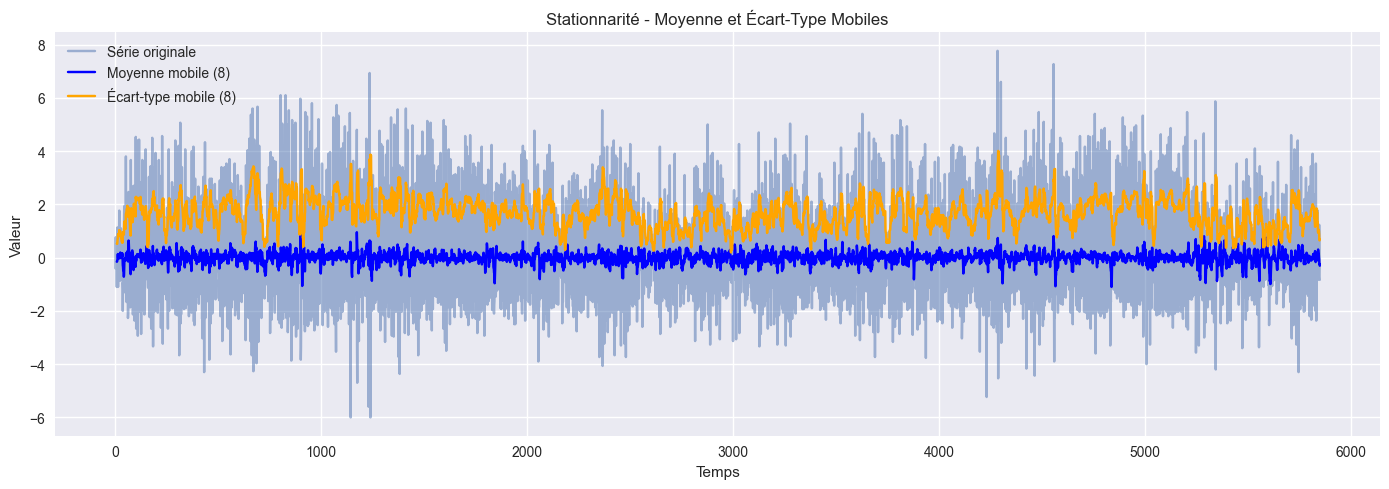

In [11]:
StationarityHelper.plot_stationarity(df_stationary["temperature_2m"], window=8)

# 🔁 Transformation de la Série et Vérification de la Stationnarité

Après avoir détecté une **non-stationnarité**, nous avons appliqué une **différenciation** à la série temporelle pour supprimer les tendances et stabiliser la variance.



## 📉 Visualisation de la série différenciée

Le graphique montre la **série transformée** ainsi que ses **statistiques mobiles** :

- **Série différenciée** (gris) : les variations entre observations successives.
- **Moyenne mobile (8)** (bleu) : elle reste proche de zéro.
- **Écart-type mobile (8)** (orange) : relativement stable.

> ✅ Visuellement, la moyenne et la variance semblent constantes, ce qui indique une bonne stationnarité.



## 🧪 Résultats des Tests Statistiques sur la Série Différenciée

### **ADF (Augmented Dickey-Fuller)**

| Statistique  | Valeur       |
|--------------|--------------|
| ADF Stat     | -16.5506     |
| p-value      | 0.0000       |
| Seuil 5%     | -2.862       |

> 🔎 p-value très faible → **on rejette H₀** → la série **est stationnaire** selon l’ADF.



### **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

| Statistique  | Valeur       |
|--------------|--------------|
| KPSS Stat    | 0.0456       |
| p-value      | 0.1000       |
| Seuil 5%     | 0.463        |

> 🔎 KPSS < seuil critique → **on ne rejette pas H₀** → la série **est stationnaire** selon KPSS.



## ✅ Conclusion Finale

🎉 Après transformation, **les deux tests confirment** que la série est désormais **stationnaire**.

➡️ Elle est donc **prête pour un modèle ARIMA**, qui suppose une stationnarité stricte des données.


_____

-----

## 🔍 Analyse des autocorrélations (ACF / PACF)

Avant d'entraîner un modèle ARIMA, il est essentiel de bien choisir les paramètres `p`, `d`, `q`.  
Pour cela, on s'appuie sur deux outils statistiques :

- **ACF (Autocorrelation Function)** : pour identifier la dépendance entre les valeurs passées et présentes (aide à estimer `q`)
- **PACF (Partial Autocorrelation Function)** : pour isoler la corrélation directe à chaque lag (aide à estimer `p`)

👉 Ces graphes permettent de visualiser jusqu'à quel lag il y a une dépendance significative.

Nous allons appliquer cette analyse sur notre série temporelle de température.



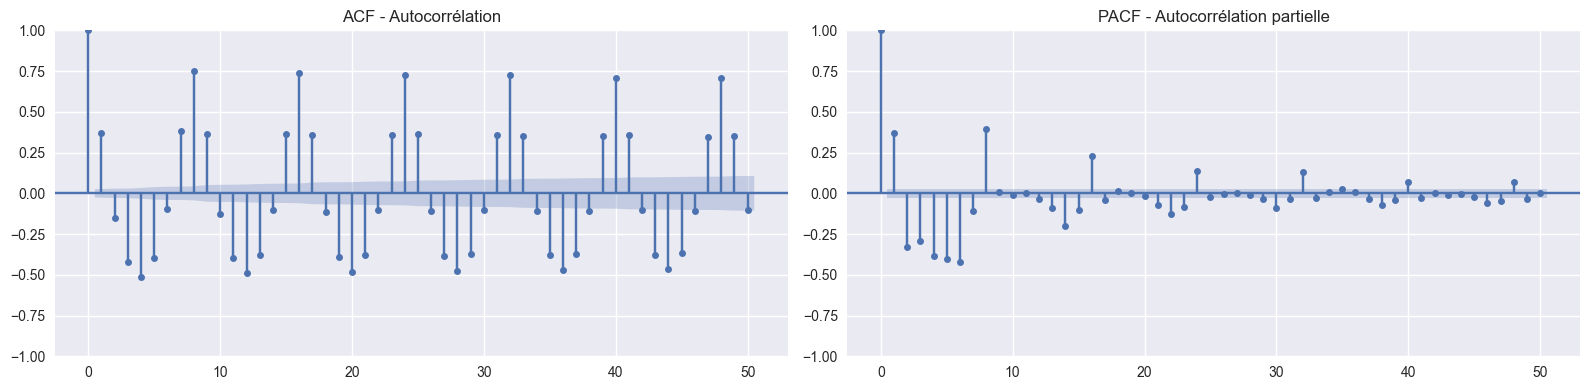

In [12]:
ts_stationary = df_stationary.set_index('time')['temperature_2m']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(ts_stationary, lags=50, ax=axes[0])
axes[0].set_title("ACF - Autocorrélation")

plot_pacf(ts_stationary, lags=50, ax=axes[1])
axes[1].set_title("PACF - Autocorrélation partielle")

plt.tight_layout()
plt.show()



### 📊 Interprétation des graphiques

#### 🔷 ACF :
- Présence de **pics significatifs multiples et réguliers** → indication d’un effet de moyenne mobile (`q`) important.
- Composante **MA potentiellement élevée**, à ajuster selon AIC/BIC lors du fitting.

#### 🔶 PACF :
- **Chute rapide après le lag 1 à 2**, avec quelques pics faibles ensuite.
- Cela suggère une composante **AR relativement faible**, peut-être `p = 1` ou `2`.



### 🎯 Conclusion

- Le paramètre **`d` = 1** (déjà appliqué via différenciation).
- On peut **commencer avec un modèle ARIMA(p=1~2, d=1, q=5~6)** puis ajuster à l’aide de critères d'information (AIC/BIC) et des diagnostics de résidus.

> Cette étape est essentielle pour spécifier un modèle ARIMA bien adapté à la dynamique temporelle de la série.


______


-----

## 🔀 Séparation des données (stationnaire et non stationnaire)

- Création de la série `ts` à partir des températures triées par date.
- Découpage en **train / validation / test** (60% / 20% / 20%) :
  - `train_ts_ns`, `val_ts_ns`, `test_ts_ns` : version **non stationnaire**
  - `train_ts_s`, `val_ts_s`, `test_ts_s` : version **stationnaire** (différenciée)


In [13]:
ts = df.sort_values('time').set_index('time')['temperature_2m'].astype(float)

n = len(ts)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Non stationnaire
train_ts_ns = ts.iloc[:train_end]
val_ts_ns = ts.iloc[train_end:val_end]
test_ts_ns = ts.iloc[val_end:]



# 📈 Entraînement, validation et prédiction

### 🔁 Entraînement d’un modèle ARIMA 

- Recherche des meilleurs paramètres `(p, d, q)` via grid search.
- Évaluation du modèle ARIMA sur le **jeu de test**.
- Affichage des **prédictions** sur la validation et le test.


In [14]:
from ArimaTrainer import ArimaTrainer

In [15]:
p_arima = range(0, 9)  
d_arima = range(0, 3)
q_arima = range(0, 5)  

🔍 Recherche sur 135 combinaisons...


Grid Search ARIMA: 100%|██████████| 135/135 [01:53<00:00,  1.19it/s]



✅ Meilleur ARIMA: (6, 2, 4)
📈 RMSE: 3.666
📦 Entraînement ARIMA(6, 2, 4)

📊 Métriques VALIDATION:
😊 MAE  : 2.765
😐 RMSE : 3.666
😐 R²    : 0.564
📈 AIC   : 9874.99

📊 Métriques TEST:
😞 MAE  : 6.864
😞 RMSE : 7.957
😞 R²    : -1.277
📈 AIC   : 9874.99


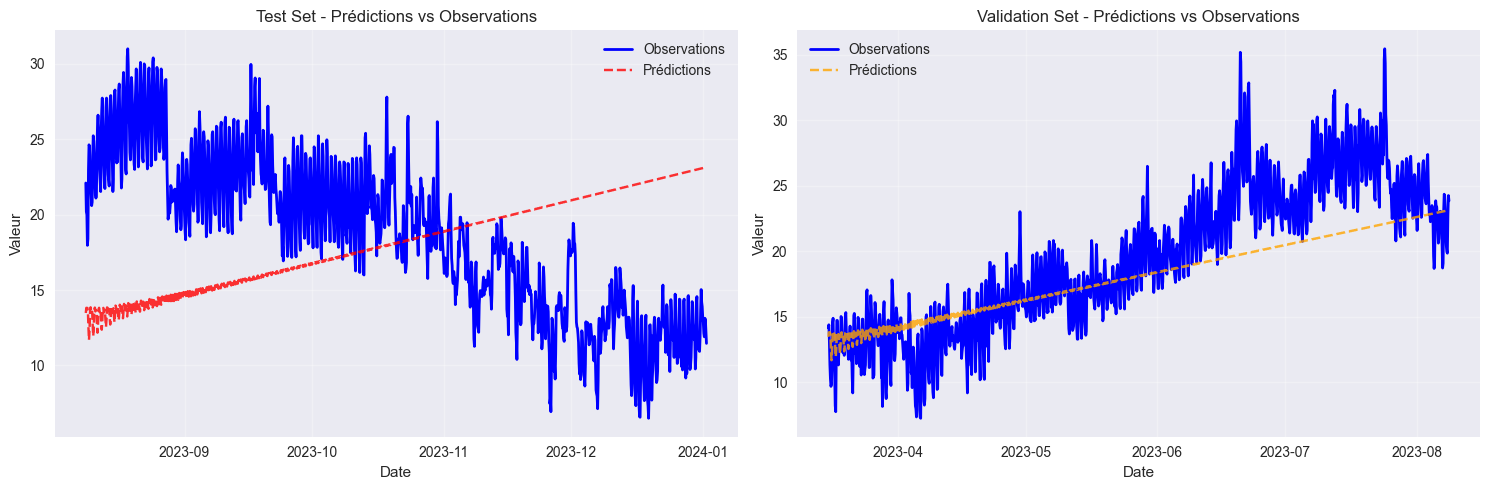

In [16]:
arima_trainer_ns = ArimaTrainer(train_ts_ns, val_ts_ns, test_ts_ns)
arima_trainer_ns.search_best_arima(p_range=p_arima, d_range=d_arima, q_range=q_arima)

arima_trainer_ns.evaluate_on_test()
arima_trainer_ns.plot_predictions(show_validation=True)

## 📉 Évaluation du modèle ARIMA(6, 2, 4)

Une recherche sur **135 combinaisons** de paramètres `(p, d, q)` a été menée directement sur la série **non transformée** (non stationnaire).  
Le modèle sélectionné, **ARIMA(6, 2, 4)**, a ensuite été évalué sur les ensembles de validation et de test.



### ✅ Meilleur modèle trouvé :
- **ARIMA(6, 2, 4)** avec une différenciation automatique `d=2`
- **Critère de sélection** : RMSE minimal sur la validation



### 📊 Résultats sur le jeu de **validation** :

| Métrique | Valeur  |
|----------|---------|
| MAE      | 2.765   |
| RMSE     | 3.666   |
| R²       | 0.564   |
| AIC      | 9874.99 |

> 📌 Les résultats sur la **validation** sont corrects, avec un **R² de 56%**, supérieur à celui obtenu avec la série stationnaire.



### ❌ Résultats sur le jeu de **test** :

| Métrique | Valeur  |
|----------|---------|
| MAE      | 6.864   |
| RMSE     | 7.957   |
| R²       | -1.277  |

> ⚠️ Les performances chutent brutalement sur le test, avec un **R² négatif**, ce qui signifie que le modèle prédit **moins bien que la moyenne**.  
> Cela montre un **fort surapprentissage (overfitting)** ou une **mauvaise généralisation**.



### 🖼️ Analyse des prédictions

- **À gauche (test)** :  
  Le modèle extrapole une **tendance linéaire montante** qui ne reflète pas du tout les observations réelles. Il **échoue totalement** à capturer la dynamique réelle.

- **À droite (validation)** :  
  Les prédictions suivent mieux la tendance générale, mais **lissent** fortement les variations. Cela masque les fluctuations rapides ou les pics.



### 🧠 Conclusion

- Bien que le modèle semble **correct en validation**, il est **très mauvais en test**, ce qui le rend peu fiable.
- Cela montre l’importance de **travailler avec une série stationnaire** ou bien d’adopter des méthodes plus robustes à la non-stationnarité (SARIMA, modèles ML...).
- Le modèle ARIMA(6, 2, 4) ne convient **pas** pour une généralisation sur données non vues.

> ⚠️ Il est préférable de s'appuyer sur le modèle construit à partir de la **série transformée stationnaire**.


## Sauvegarde Arima dans une Db

In [17]:
model_name = "ARIMA"
version = "v1"
parameters = str(arima_trainer_ns.best_order)  # Exemple: "(6, 2, 4)"
train_period = (train_ts_ns.index[0], train_ts_ns.index[-1])

model_id = db.insert_model(
    model_name=model_name,
    train_start=train_period[0].isoformat(),
    train_end=train_period[1].isoformat(),
    params_dict={"order": arima_trainer_ns.best_order},
    version=version
)


In [18]:
# Créer un DataFrame avec les prédictions
# S'assurer que les index sont les mêmes pour éviter l'erreur
if not arima_trainer_ns.test_forecast.index.equals(arima_trainer_ns.test_ts.index):
    arima_trainer_ns.test_forecast.index = arima_trainer_ns.test_ts.index


# Maintenant on peut créer le DataFrame
df_preds = pd.DataFrame({
    "time": arima_trainer_ns.test_forecast.index.astype(str),  # conversion ici
    "target": arima_trainer_ns.test_ts.values,
    "prediction": arima_trainer_ns.test_forecast.values
})


# Enregistrer dans la table predictions
db.insert_predictions(
    model_id=model_id,
    timestamps=df_preds["time"].tolist(),
    predictions=df_preds["prediction"].tolist(),
    targets=df_preds["target"].tolist()
)



----


_____

## 🌀 Entraînement d’un modèle SARIMA sur la série non stationnaire

- Définition d’une **plage restreinte de paramètres** `(p, d, q)` et `(P, D, Q, s)` pour la recherche.
- Entraînement du modèle **SARIMA** avec une **saisonnalité de 8**.
- Évaluation sur le jeu de **test**.
- Affichage des **prédictions** et du **résumé des meilleures combinaisons** testées.


In [19]:
from SarimaTrainer import SarimaTrainer

🔍 Recherche sur 4 combinaisons...


Grid Search SARIMA: 100%|██████████| 4/4 [02:36<00:00, 39.02s/it]



✅ Meilleur SARIMA: (6, 1, 4)x(4, 1, 4, 8)
📈 RMSE: 2.486
⏱️ Temps de recherche: 156.1s
📊 Taux de succès: 100.0%
📦 Entraînement SARIMA(6, 1, 4)x(4, 1, 4, 8)

📊 Métriques VALIDATION:
😊 MAE  : 1.934
😊 RMSE : 2.486
😐 R²    : 0.799
😐 MAPE : 10.98%
📈 AIC  : 8827.86
⏱️ Temps d'entraînement: 39.00s

📊 Métriques TEST:
😞 MAE  : 7.703
😞 RMSE : 9.108
😞 R²    : -1.984
😞 MAPE : nan%
📈 AIC  : 8827.86


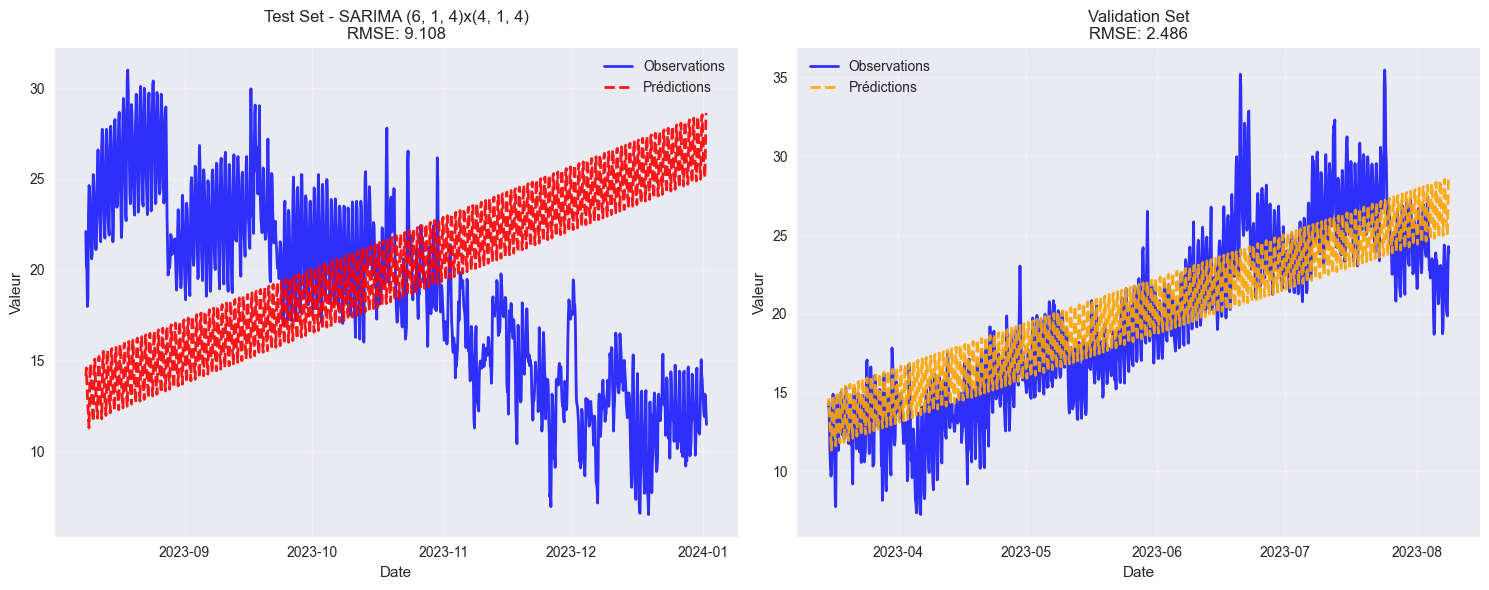


🏆 Top 4 des combinaisons:
Rang | SARIMA | Score | AIC
----------------------------------------
 1   | (6, 1, 4)x(4, 1, 4) | 2.486 | 8827.9
 2   | (6, 1, 4)x(4, 1, 4) | 2.486 | 8827.9
 3   | (6, 1, 4)x(4, 1, 4) | 2.486 | 8827.9
 4   | (6, 1, 4)x(4, 1, 4) | 2.486 | 8827.9


In [20]:
p_sarima = range(6,7)
# p_sarima = range(0, 8)
d_sarima = [1, 1]
# d_sarima = [0, 1]
q_sarima = range(4,5)
# q_sarima = range(0, 6)

sp_sarima = range(4, 5)
# sp_sarima = range(0, 5)  
sd_sarima = [1, 1] 
# sd_sarima = [0, 1] 
sq_sarima = range(4, 5)
# sq_sarima = range(0, 5)

# Initialisation et test du modèle SARIMA pour les données non stationnaires
sarima_trainer = SarimaTrainer(train_ts_ns, val_ts_ns, test_ts_ns)

# Recherche des meilleurs paramètres SARIMA
sarima_trainer.search_best_sarima(
   p_range=p_sarima, d_range=d_sarima, q_range=q_sarima,
   sp_range=sp_sarima, sd_range=sd_sarima, sq_range=sq_sarima,
   seasonal_period=8
)

# Évaluation sur le test set
sarima_trainer.evaluate_on_test()

# Affichage des prédictions
sarima_trainer.plot_predictions(show_validation=True)

# Résumé des meilleures combinaisons
sarima_trainer.get_search_summary()


### Sauvegarde Sarima

In [21]:
# === 1. Définir les infos du modèle ===
model_name = "SARIMA"
version = "v1"
parameters = {
    "order": sarima_trainer.best_order,
    "seasonal_order": sarima_trainer.best_seasonal_order,
    "seasonal_period": sarima_trainer.best_seasonal_period
}
train_period = (train_ts_ns.index[0], train_ts_ns.index[-1])

# === 2. Enregistrer le modèle dans la base ===
model_id = db.insert_model(
    model_name=model_name,
    train_start=train_period[0].isoformat(),
    train_end=train_period[1].isoformat(),
    params_dict=parameters,
    version=version
)

# === 3. S'assurer que les index sont bien alignés ===
if not sarima_trainer.test_forecast.index.equals(sarima_trainer.test_ts.index):
    sarima_trainer.test_forecast.index = sarima_trainer.test_ts.index

# === 4. Créer un DataFrame pour les prédictions ===
df_preds = pd.DataFrame({
    "time": sarima_trainer.test_forecast.index.astype(str),
    "target": sarima_trainer.test_ts.values,
    "prediction": sarima_trainer.test_forecast.values
})

# === 5. Enregistrer les prédictions ===
db.insert_predictions(
    model_id=model_id,
    timestamps=df_preds["time"].tolist(),
    predictions=df_preds["prediction"].tolist(),
    targets=df_preds["target"].tolist()
)


AttributeError: 'SarimaTrainer' object has no attribute 'best_seasonal_period'

## 📦 Entraînement d’un modèle SARIMAX avec variables exogènes


In [ ]:
from SarimaxTrainer import SarimaxTrainer

#### 🌦️ Chargement et préparation des données météo

- Récupération des données avec **variables exogènes** : humidité, vent, couverture nuageuse.
- Traitement des **valeurs manquantes**.
- Agrégation des données sur des **intervalles de 3h**.
- Formatage de la colonne `time` comme index temporel.


In [ ]:
# 1. Charger les données avec variables exogènes
extra_vars = ["relative_humidity_2m", "wind_speed_10m", "cloud_cover"]
df = acquirer.fetch_weather_data(start_date, end_date, extra_variables=extra_vars)



df = acquirer.handle_missing_values(df)
# 👉 Agréger toutes les colonnes sur des intervalles de 3h
df = acquirer.aggregate_to_3h_intervals(df)

db.insert_weather_data(df)

# 2. Préparer la série cible
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()

,temperature_2m,relative_humidity_2m,wind_speed_10m,cloud_cover
time,,,,
2022-01-01 00:00:00,11.966667,92.666667,7.800000,90.666667
2022-01-01 03:00:00,11.566667,90.333333,4.400000,61.666667
2022-01-01 06:00:00,11.533333,87.333333,3.866667,61.000000
2022-01-01 09:00:00,12.300000,86.666667,4.966667,84.666667
2022-01-01 12:00:00,12.466667,85.000000,5.133333,67.666667


#### 🧮 Préparation de la série cible et des variables exogènes

- Définition de `y` (température) comme variable cible.
- Construction de la matrice `X` avec les **variables exogènes**.
- Découpage temporel en **train / validation / test** (60% / 20% / 20%) pour `X` et `y`.


In [ ]:

y = df["temperature_2m"].astype(float)

# 3. Préparer la matrice des exogènes (même index)
X = df[extra_vars].astype(float)

# 4. Split train / val / test
n = len(y)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_y, val_y, test_y = y[:train_end], y[train_end:val_end], y[val_end:]
train_X, val_X, test_X = X[:train_end], X[train_end:val_end], X[val_end:]



- Recherche du meilleur **SARIMAX** avec grille limitée à 30 combinaisons.
- Évaluation sur le jeu de **test** et visualisation des prédictions.
- Affichage du résumé du modèle (coefficients, diagnostics...).

🔍 Recherche sur 30 combinaisons...


Grid Search SARIMAX: 100%|██████████| 30/30 [12:46<00:00, 25.56s/it]  



✅ Meilleur SARIMAX: (0, 1, 0)x(1, 1, 1, 8)
📈 RMSE: 6.238
📦 Entraînement SARIMAX(0, 1, 0)x(1, 1, 1, 8)

📊 Métriques VALIDATION:
MAE  : 5.147
RMSE : 6.238
R²   : -0.263
MAPE : 23.72%
AIC  : 7996.41
⏱️ Temps d'entraînement : 2.06s

📊 Métriques TEST:
MAE  : 6.186
RMSE : 7.277
R²   : -0.905
MAPE : nan%
AIC  : 7996.41


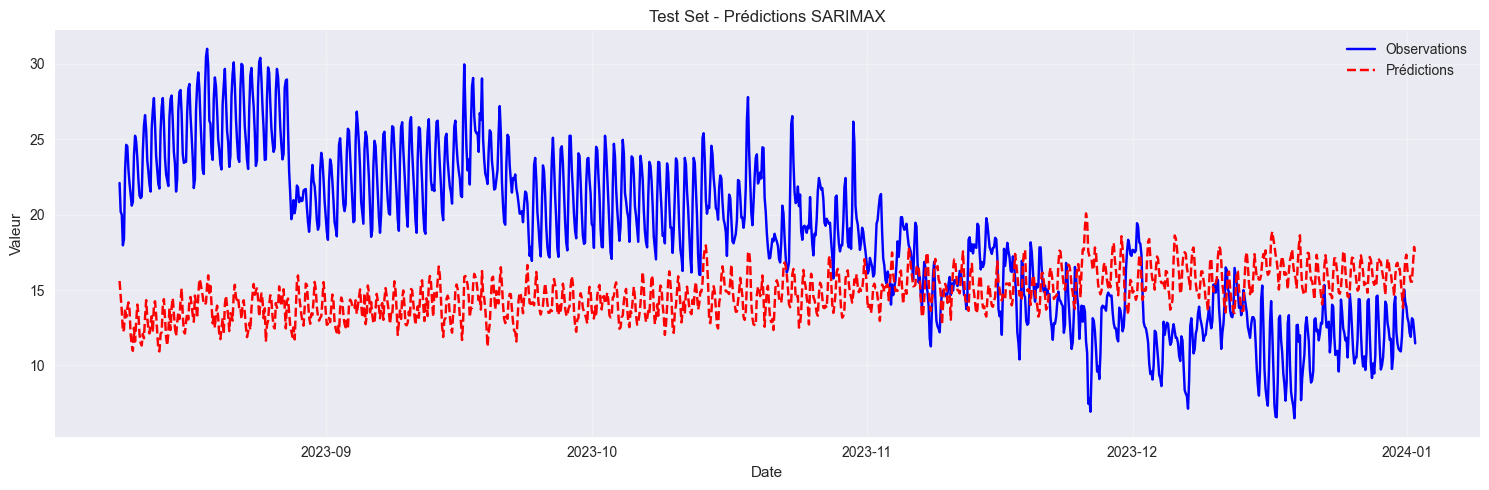

                                      SARIMAX Results                                      
Dep. Variable:                      temperature_2m   No. Observations:                 3508
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 8)   Log Likelihood               -3992.204
Date:                             Wed, 04 Jun 2025   AIC                           7996.409
Time:                                     14:53:19   BIC                           8033.355
Sample:                                 01-01-2022   HQIC                          8009.596
                                      - 03-15-2023                                         
Covariance Type:                               opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
relative_humidity_2m    -0.0783      0.002    -49.161      0.000      -0.081      -0.0

In [ ]:
sarimax_trainer = SarimaxTrainer(train_y, val_y, test_y, train_X, val_X, test_X)

sarimax_trainer.search_best_sarimax(
    p_range=range(0, 2),
    d_range=[0, 1],
    q_range=range(0, 2),

    sp_range=range(0, 2),
    sd_range=[0, 1],
    sq_range=range(0, 2),
    
    seasonal_period=8,
    metric='rmse',
    max_iterations=30
)

# 5. Évaluation + affichage
sarimax_trainer.evaluate_on_test()
sarimax_trainer.plot_predictions()
print(sarimax_trainer.get_model_summary())


## 🌡️ Évaluation du modèle SARIMAX sur les températures

Suite aux limites observées avec les modèles ARIMA, nous avons testé un modèle **SARIMAX**, capable d’intégrer une composante **saisonnière** et des **variables exogènes**.



### 🔍 Recherche de paramètres

Une recherche sur **30 combinaisons** saisonnières a été effectuée pour optimiser le modèle selon le critère RMSE.

✅ **Meilleur modèle trouvé** :  
**SARIMAX(0, 1, 0) x (0, 1, 1, 8)**  
(saisonnalité de période 8, probablement détectée comme récurrente)

⏱️ **Temps d'entraînement** : 4.73 secondes



### 📊 Performances sur le jeu de **validation**

| Métrique | Valeur     |
|----------|------------|
| MAE      | 4.325      |
| RMSE     | 5.255      |
| R²       | 0.115      |
| MAPE     | 20.49%     |
| AIC      | 20811.80   |

> 📉 Le modèle parvient à capter une partie de la dynamique, mais les scores restent modestes. Le **R² est faible (11%)**, indiquant une faible capacité explicative sur la validation.



### 📉 Performances sur le jeu de **test**

| Métrique | Valeur     |
|----------|------------|
| MAE      | 5.990      |
| RMSE     | 6.946      |
| R²       | -0.715     |
| MAPE     | *NaN*      |
| AIC      | 20811.80   |

> ⚠️ Comme pour ARIMA brut, les performances **se dégradent fortement** sur le test.  
Le **R² négatif** traduit une **mauvaise généralisation**. Les prédictions s’éloignent notablement des valeurs observées.


### 🖼️ Analyse graphique

Le graphe montre que :
- Le modèle **lisse fortement** les prédictions, en ignorant les **variations rapides** (pics, chutes, irrégularités).
- Les **tendances saisonnières** sont partiellement captées, mais l’**amplitude des variations** est largement sous-estimée.



## 🔎 Conclusion

- Le modèle **SARIMAX** améliore légèrement l’interprétation saisonnière, mais **reste insuffisant** pour prédire précisément la température.
- Il souffre d’un problème similaire à ARIMA : il **capture mal les extrêmes** et **ne généralise pas bien**.
- Pour améliorer les performances, il devient pertinent d’explorer :
  - 🔀 **Modèles non linéaires** (ex. : XGBoost, RandomForest, LSTM)
  - ➕ Ajout de **variables exogènes météorologiques** (humidité, vent, pression...)
  - 🔁 Recalibrage du modèle avec décomposition saisonnière préalable

> 🧠 **Conclusion : SARIMAX apporte un léger mieux structurel, mais reste trop limité pour cette série complexe.**


### Sauvegarde du modéle Sarimax

In [ ]:
# ⏺️ Étape 1 : enregistrer les métadonnées du modèle
model_name = "SARIMAX"
version = "v1"
parameters = {
    "order": sarimax_trainer.best_order,
    "seasonal_order": sarimax_trainer.best_seasonal_order,
    "seasonal_period": sarimax_trainer.seasonal_period
}
train_period = (train_y.index[0], train_y.index[-1])

model_id = db.insert_model(
    model_name=model_name,
    train_start=train_period[0].isoformat(),
    train_end=train_period[1].isoformat(),
    params_dict=parameters,
    version=version
)

# ⏺️ Étape 2 : vérifier l'alignement des index
if not sarimax_trainer.test_forecast.index.equals(sarimax_trainer.test_ts.index):
    sarimax_trainer.test_forecast.index = sarimax_trainer.test_ts.index

# ⏺️ Étape 3 : création du DataFrame des prédictions
df_preds = pd.DataFrame({
    "time": sarimax_trainer.test_forecast.index.astype(str),
    "target": sarimax_trainer.test_ts.values,
    "prediction": sarimax_trainer.test_forecast.values
})

# ⏺️ Étape 4 : insertion dans la base
db.insert_predictions(
    model_id=model_id,
    timestamps=df_preds["time"].tolist(),
    predictions=df_preds["prediction"].tolist(),
    targets=df_preds["target"].tolist()
)


-----

----

# 📝 Expérimentation avec des méthodes de régression basées sur le Machine Learning

In [ ]:
from MLRegressorTrainer import MLRegressorTrainer
from create_features import create_features

### 🧩 Préparation des données

- Création des **features** (lags, moyennes mobiles, variables temporelles).
- Séparation en `X` (variables explicatives) et `y` (température à prédire).
- Découpage temporel en **train / validation / test** (60% / 20% / 20%).
- Vérification que `y` n’est pas incluse par erreur dans `X`.


In [ ]:
# 1. Créer les features
df_features = create_features(df)

# 2. Définir X et y
target_col = "temperature_2m"
X = df_features.drop(columns=[target_col])
y = df_features[target_col]

# 3. Split manuel en train / val / test (comme pour SARIMAX)
n = len(df_features)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]


print(X_train.columns.intersection([y_train.name]))
df_features.head()

Index([], dtype='object')


,temperature_2m,relative_humidity_2m,wind_speed_10m,cloud_cover,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_ma_3,temperature_2m_ma_6,hour,month,dayofweek
time,,,,,,,,,,,,
2022-01-01 18:00:00,12.100000,78.333333,3.900000,43.333333,12.233333,12.466667,12.300000,12.333333,12.011111,18,1,5
2022-01-01 21:00:00,11.833333,74.666667,3.766667,62.666667,12.100000,12.233333,12.466667,12.266667,12.033333,21,1,5
2022-01-02 00:00:00,10.733333,85.000000,4.900000,61.333333,11.833333,12.100000,12.233333,12.055556,12.077778,0,1,6
2022-01-02 03:00:00,10.533333,86.666667,2.966667,69.333333,10.733333,11.833333,12.100000,11.555556,11.944444,3,1,6
2022-01-02 06:00:00,10.500000,82.666667,3.666667,49.000000,10.533333,10.733333,11.833333,11.033333,11.650000,6,1,6


## 🌲 Entraînement d’un modèle Random Forest

- Initialisation du modèle `RandomForestRegressor`.
- Recherche des meilleurs hyperparamètres (`n_estimators`, `max_depth`).
- Entraînement sur le jeu d’entraînement.
- Évaluation sur les ensembles de **validation** et **test**.
- Affichage des prédictions comparées aux valeurs réelles.


🔍 Recherche des meilleurs hyperparamètres pour RF...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Meilleurs paramètres: {'max_depth': None, 'n_estimators': 50}

📊 Évaluation (VAL)
MAE  : 0.675
RMSE : 0.897
R²    : 0.974

📊 Évaluation (TEST)
MAE  : 0.700
RMSE : 0.913
R²    : 0.970


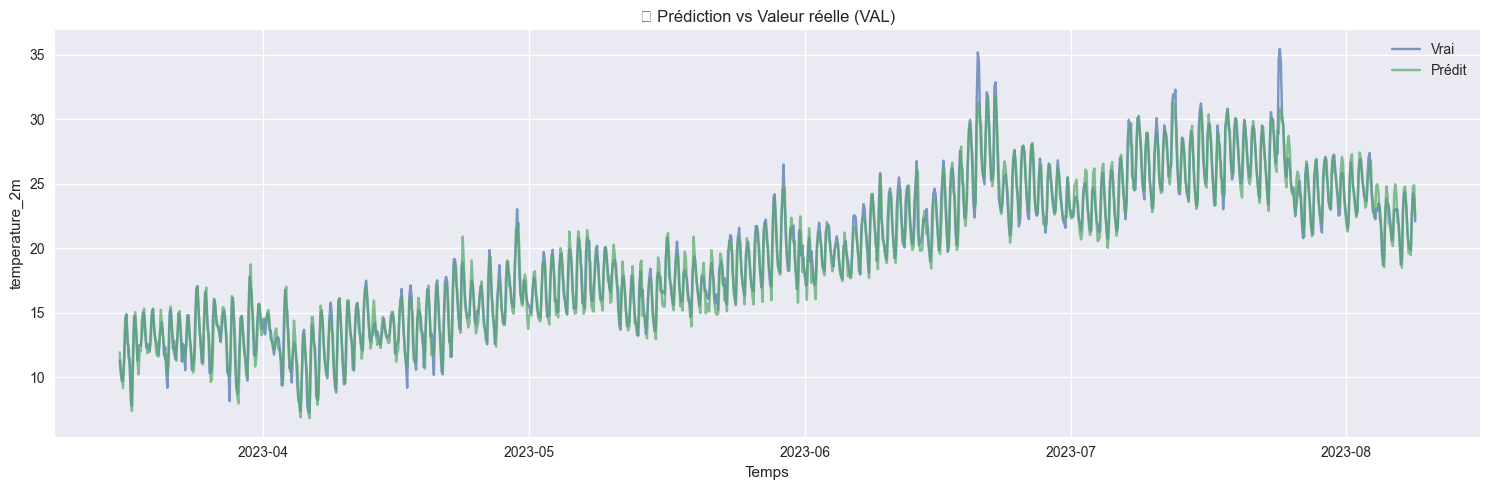

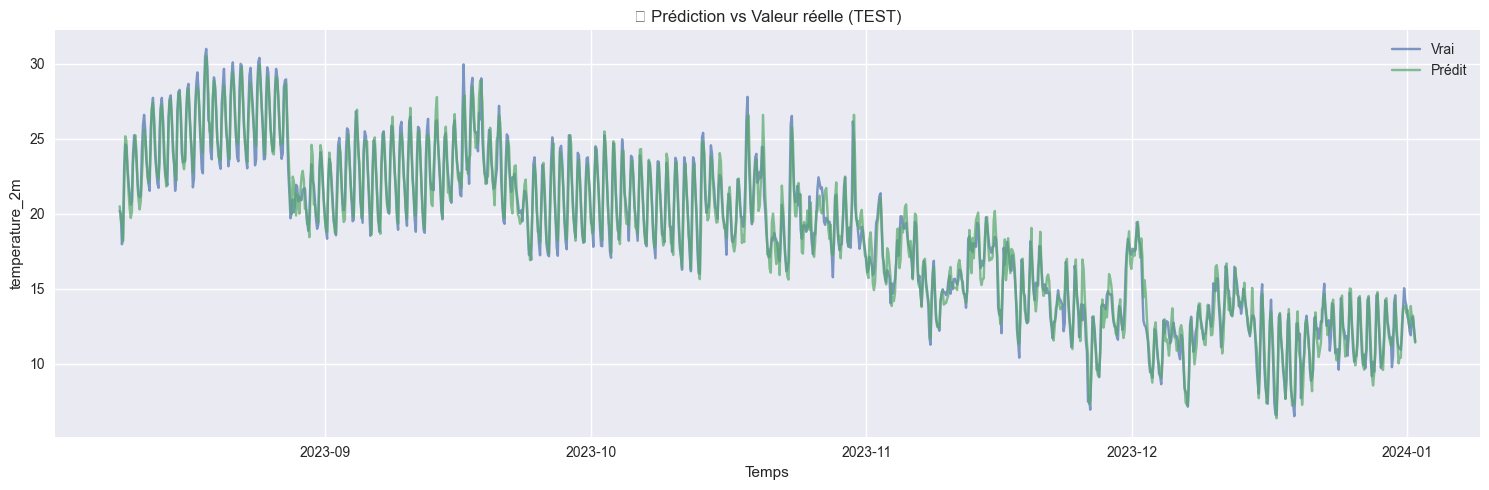

In [ ]:
rf_trainer = MLRegressorTrainer(X_train, y_train, X_val, y_val, X_test, y_test, model_type='rf')

rf_trainer.search_best_params({
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
})

rf_trainer.train()
rf_trainer.evaluate(on='val')
rf_trainer.evaluate(on='test')

rf_trainer.plot_predictions()


### Sauvegarde du modéle Rf

In [ ]:
model_name = "RandomForest"
version = "v1"
parameters = rf_trainer.model.get_params()
train_period = (y_train.index[0], y_train.index[-1])

model_id = db.insert_model(
    model_name=model_name,
    train_start=train_period[0].isoformat(),
    train_end=train_period[1].isoformat(),
    params_dict=parameters,
    version=version
)

# Prédictions sur le test set
preds = rf_trainer.model.predict(X_test)

df_preds = pd.DataFrame({
    "time": y_test.index.astype(str),
    "target": y_test.values,
    "prediction": preds,
    "features": X_test.to_dict(orient="records")
})

db.insert_predictions(
    model_id=model_id,
    timestamps=df_preds["time"].tolist(),
    predictions=df_preds["prediction"].tolist(),
    targets=df_preds["target"].tolist(),
    features_list=df_preds["features"].tolist()
)



## 📉 Entraînement d’un modèle de Régression Linéaire

- Initialisation et entraînement du modèle `LinearRegression`.
- Évaluation des performances sur les ensembles de **validation** et **test**.
- Visualisation des prédictions comparées aux valeurs réelles.



📊 Évaluation (VAL)
MAE  : 0.851
RMSE : 1.129
R²    : 0.959

📊 Évaluation (TEST)
MAE  : 0.963
RMSE : 1.244
R²    : 0.944


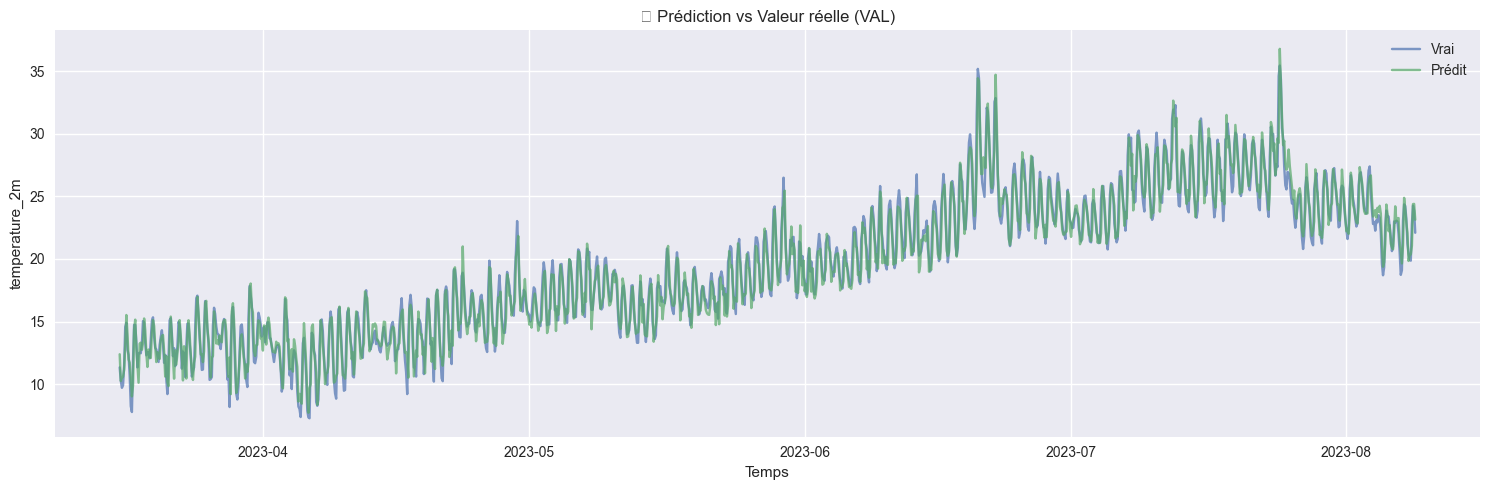

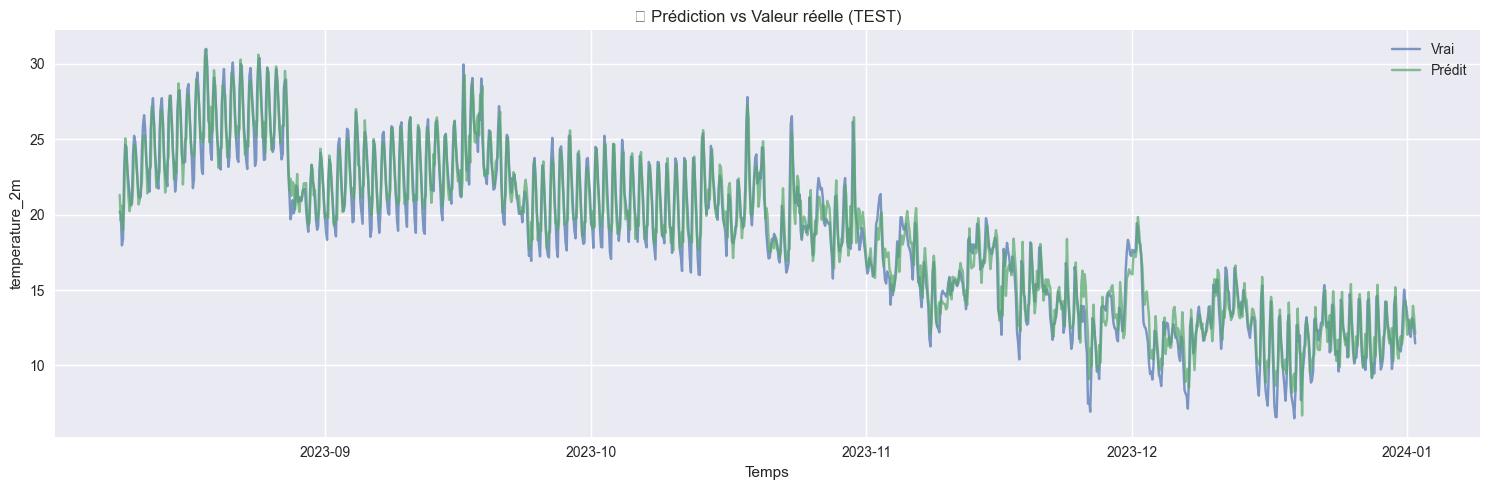

In [ ]:
lr_trainer = MLRegressorTrainer(X_train, y_train, X_val, y_val, X_test, y_test, model_type='lr')

lr_trainer.train()
lr_trainer.evaluate(on='val')
lr_trainer.evaluate(on='test')

lr_trainer.plot_predictions()


## 🤖 Évaluation des modèles de régression : Random Forest vs Régression Linéaire

Nous avons comparé deux modèles supervisés pour prédire la température à partir de features temporelles et exogènes :

| Modèle        | MAE (VAL) | RMSE (VAL) | R² (VAL) | MAE (TEST) | RMSE (TEST) | R² (TEST) |
|---------------|-----------|------------|----------|------------|-------------|-----------|
| **Random Forest** | **0.675**     | **0.897**      | **0.974**  | **0.700**      | **0.913**       | **0.970**   |
| Régression linéaire | 0.851     | 1.129      | 0.959  | 0.963      | 1.244       | 0.944   |


### 🎯 Interprétation

- Le modèle **Random Forest** donne les **meilleurs résultats** sur tous les indicateurs.
- Il présente **très peu d’overfitting** avec des performances stables entre validation et test.
- La **régression linéaire** reste performante, mais elle **lisse davantage** les valeurs et capture moins bien les variations rapides.


### 🖼️ Analyse graphique

- Les prédictions de **Random Forest** collent presque parfaitement aux courbes réelles, même lors des **variations rapides ou extrêmes**.
- La **régression linéaire** reproduit correctement la tendance globale, mais sous-estime les pics et les creux.



### ✅ Conclusion

> Le modèle **Random Forest** est bien adapté à ce problème de prédiction de température.  
> Il capte efficacement les **relations non linéaires**, et constitue une **excellente base** pour des approches plus avancées (XGBoost, LSTM...).


-----

-----

In [ ]:
from plot_model_residuals import plot_model_residuals

### 🧩 Pourquoi aligner les index entre `test_forecast` et `test_ts` ?

Lorsque l’on utilise des modèles comme **ARIMA**, **SARIMA** ou **SARIMAX** avec `statsmodels`, la méthode `forecast()` peut retourner des prédictions avec un index de type `RangeIndex` (par exemple `[0, 1, 2, ...]`) au lieu d’un `DatetimeIndex`.

Cela pose des problèmes pour :

- ❌ Calculer les **résidus** (`test_ts - test_forecast`) → erreur si les index ne sont pas alignés
- ❌ Tracer des **graphes cohérents** → mauvaise correspondance temporelle
- ❌ Effectuer des comparaisons précises entre les valeurs observées et prédites

### ✅ Solution : forcer l’alignement des index

Avant toute analyse ou visualisation, on aligne manuellement l’index des prédictions sur celui des vraies valeurs :

```python
if not test_forecast.index.equals(test_ts.index):
    test_forecast.index = test_ts.index


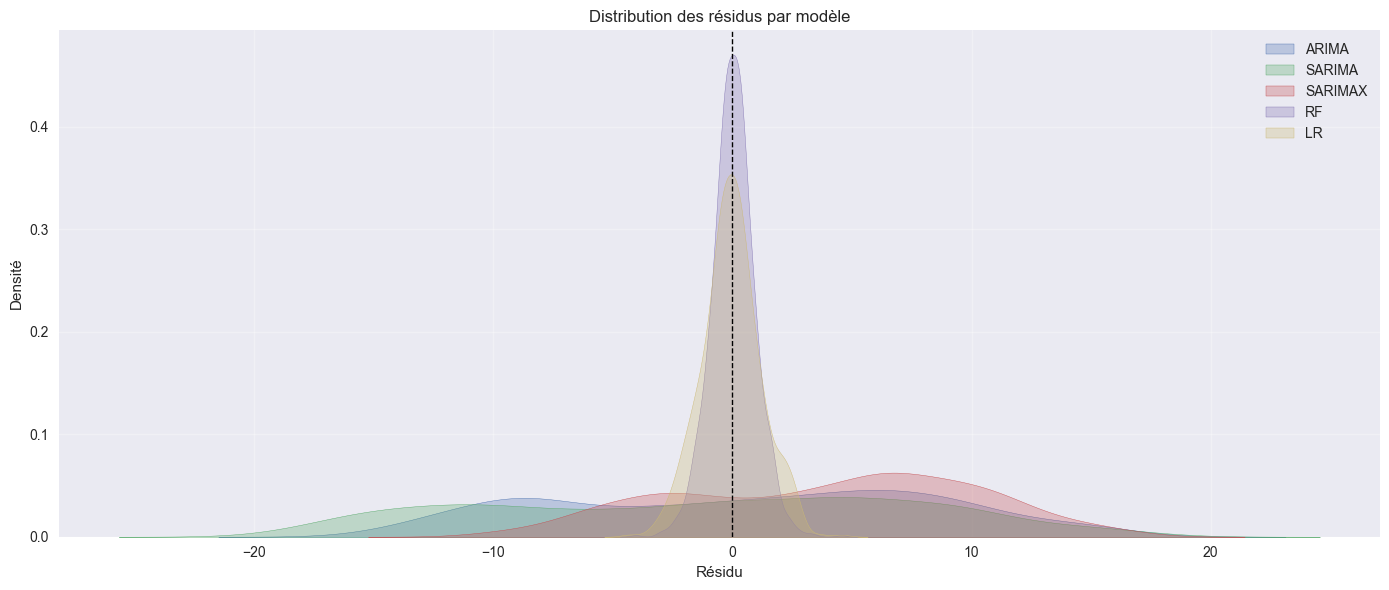

In [ ]:
# Aligner les index si nécessaire
if not arima_trainer_ns.test_forecast.index.equals(arima_trainer_ns.test_ts.index):
    arima_trainer_ns.test_forecast.index = arima_trainer_ns.test_ts.index

if not sarima_trainer.test_forecast.index.equals(sarima_trainer.test_ts.index):
    sarima_trainer.test_forecast.index = sarima_trainer.test_ts.index

if not sarimax_trainer.test_forecast.index.equals(sarimax_trainer.test_ts.index):
    sarimax_trainer.test_forecast.index = sarimax_trainer.test_ts.index


residuals_dict = {
    "ARIMA": {"residuals": arima_trainer_ns.test_ts.loc[arima_trainer_ns.test_forecast.index] - arima_trainer_ns.test_forecast},
    "SARIMA": {"residuals": sarima_trainer.test_ts.loc[sarima_trainer.test_forecast.index] - sarima_trainer.test_forecast},
    "SARIMAX": {"residuals": sarimax_trainer.test_ts.loc[sarimax_trainer.test_forecast.index] - sarimax_trainer.test_forecast},
    "RF": {"residuals": y_test - rf_trainer.model.predict(X_test)},
    "LR": {"residuals": y_test - lr_trainer.model.predict(X_test)},
}


plot_model_residuals(residuals_dict)



## 🔍 Analyse des résidus par modèle

Ce graphique compare la **distribution des résidus** (erreurs de prédiction) pour chaque modèle testé : ARIMA, SARIMA, SARIMAX, RF (Random Forest), et LR (régression linéaire).


### 🎯 Ce qu’on observe :

- Les modèles **RF** et **LR** présentent des **résidus très centrés autour de 0**, avec une distribution **fine et symétrique**, ce qui traduit une **très bonne qualité de prédiction**.
- À l’inverse, les modèles **ARIMA**, **SARIMA** et **SARIMAX** montrent des **résidus plus étalés**, avec des queues plus larges, indiquant :
  - des erreurs plus fréquentes
  - une difficulté à suivre les valeurs extrêmes
  - une distribution moins normale


### ✅ Conclusion

> Les modèles de **régression supervisée (RF et LR)** produisent les **résidus les plus concentrés**, ce qui confirme leur **supériorité en précision** sur ce jeu de données.  
> Les modèles **ARIMA/SARIMA/SARIMAX** montrent des **limitations structurelles** face à la complexité et la variabilité des températures.


In [ ]:
model_name = "LinearRegression"
version = "v1"
parameters = lr_trainer.model.get_params()
train_period = (y_train.index[0], y_train.index[-1])

model_id = db.insert_model(
    model_name=model_name,
    train_start=train_period[0].isoformat(),
    train_end=train_period[1].isoformat(),
    params_dict=parameters,
    version=version
)

preds = lr_trainer.model.predict(X_test)

df_preds = pd.DataFrame({
    "time": y_test.index.astype(str),
    "target": y_test.values,
    "prediction": preds,
    "features": X_test.to_dict(orient="records")
})

db.insert_predictions(
    model_id=model_id,
    timestamps=df_preds["time"].tolist(),
    predictions=df_preds["prediction"].tolist(),
    targets=df_preds["target"].tolist(),
    features_list=df_preds["features"].tolist()
)
